# Swordfish usage example -- Information Geometry

In [13]:
import swordfish as sf
import numpy as np
import pylab as plt
from numpy.random import multivariate_normal
from tqdm import tqdm
%matplotlib inline

## Example model definition

### Signal and background fluxes

In [14]:
x = np.linspace(1., 10., 101); dx = x[1]-x[0]

sig_width = 2.
flux_func = lambda sig_norm, sig_pos, bkg_norm: (
    sig_norm/np.sqrt(2*np.pi*sig_width**2)*np.exp(-(x-sig_pos)**2./2./sig_width**2)/sig_pos
    + bkg_norm*np.ones_like(x)
    )*dx

### Background covariance

In [15]:
X,Y = np.meshgrid(x,x)
width = 1.
stddev = 0.005
Sigma = np.exp(-(X-Y)**2/2/width**2)*stddev**2

### Exposure

In [16]:
exposure = np.ones_like(x)*400.

## Upper limits with the effective counts method

100%|██████████| 40/40 [00:00<00:00, 81.86it/s]


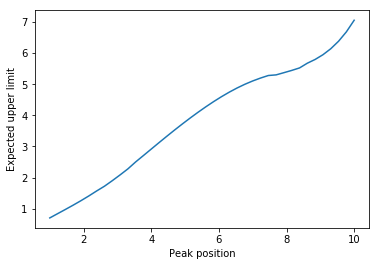

In [17]:
sig_norm = 0.
bkg_norm = 1.
pos_list = np.linspace(1, 10, 40)
ul_list = []

for sig_pos in tqdm(pos_list):
    flux = sf.func_to_templates(flux_func, [sig_norm, sig_pos, bkg_norm])
    flux = [flux[0], flux[2]]
    noise = flux_func(sig_norm, sig_pos, bkg_norm)
    SF = sf.Swordfish(flux, noise, Sigma, exposure, verbose=False)
    EC = sf.EffectiveCounts(SF)
    alpha = 0.05
    UL = EC.upperlimit(alpha, 0)
    ul_list.append(UL)
plt.plot(pos_list, ul_list)
plt.xlabel("Peak position")
plt.ylabel("Expected upper limit")

## Reconstruction power

### Map Fisher matrix

In [18]:
bkg_norm = 1.
norm_list = np.linspace(1, 20, 50)
I_table = []

for sig_norm in tqdm(norm_list):
    I_row = []
    for sig_pos in pos_list:
        #print sig_pos
        flux = sf.func_to_templates(flux_func, [sig_norm, sig_pos, bkg_norm])
        #print flux[0].mean(), flux[1].mean()
        noise = flux_func(sig_norm, sig_pos, bkg_norm)
        SF = sf.Swordfish(flux, noise, Sigma, exposure, verbose=False)
        #I = SF.fishermatrix()
        Ieff = SF.effectivefishermatrix([1,0])
        I_row.append(Ieff)
    I_table.append(I_row)
    #print np.array(I_row)[:,1,1].mean()
I_table = np.array(I_table)

100%|██████████| 50/50 [00:05<00:00,  9.64it/s]


### Quiver plot showing major and minor axis of Fisher information metric
Useful for cross-checks. If the figures shows dis-continuities, probably the sample grid needs to be finer.

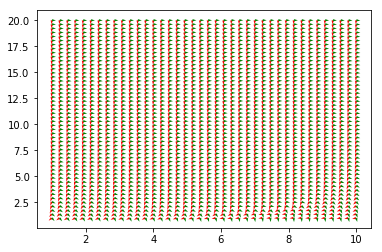

In [19]:
tf = sf.TensorField(pos_list, norm_list, I_table)
tf.quiver()

### 1, 2, 3-sigma contours from geodesics

(0, 20)

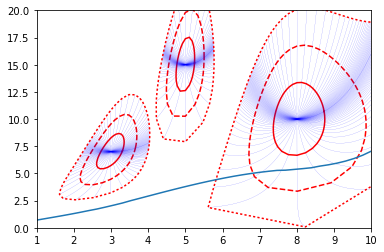

In [23]:
def plot_contours(pos, norm):
    for th, ls, pg in zip([1., 2., 3.], ['-', '--', ':'], [False, False, True]):
        contour = tf.get_contour([pos, norm], th, plot_geodesics = pg, Npoints = 128)
        plt.plot(contour.T[0], contour.T[1], color='r', ls=ls)
                
plot_contours(8., 10.0)
plot_contours(3., 7.0)
plot_contours(5., 15.0)
     
plt.plot(pos_list, ul_list)
plt.xlim([1, 10])
plt.ylim([0, 20])

### Visualization of information metric with streamlines

(0, 20)

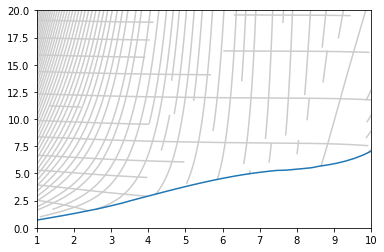

In [21]:
vf1, vf2 = tf.get_VectorFields()
mask = lambda x, y: (y<20) & (y>np.interp(x, pos_list, ul_list)) & (x>1) & (x<10)
lines = vf1.get_streamlines([5,12.], Nmax = 80, Nsteps = 30, mask = mask)
for line in lines:
    plt.plot(line.T[0], line.T[1], '0.8')
lines = vf2.get_streamlines([5,12.], Nmax = 80, Nsteps = 30, mask = mask)
for line in lines:
    plt.plot(line.T[0], line.T[1], '0.8')

plt.plot(pos_list, ul_list)
plt.xlim([1, 10])
plt.ylim([0, 20])

### Jeffereys prior as estimate for model reconstruction density

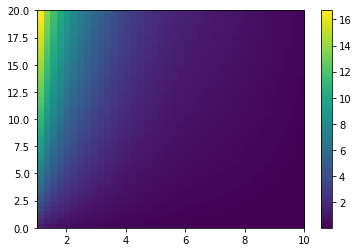

In [22]:
jp = np.array([[np.linalg.det(g)**0.5 for g in row] for row in I_table])
extent = (1, 10, 0, 20)
plt.imshow(jp[::-1], extent = extent, aspect='auto')
plt.colorbar()